In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df_users = pd.read_csv('users.csv')
df_funnel = pd.read_csv('funnel_path.csv')

## Data Cleaning & Data Preprocessing

In [3]:
# Define order of the funnel steps for data_funnel
custom_order = ['started_navigator', 'collect_contact_info', 'viewed_quotes','application_submit','phone_connect','sign_and_exam']
df_funnel['funnel_steps'] = pd.Categorical(df_funnel['funnel_steps'], categories=custom_order, ordered=True)
# Sort the DataFrame based on the custom-ordered 'value' column
df_funnel = df_funnel.sort_values(by='funnel_steps')

In [4]:
# Recalculate the conversion-rate to have thia information here
users_at_each_step = df_funnel['funnel_steps'].value_counts()

# Number of users who started the navigator
initial_users_count = users_at_each_step['started_navigator']

# Calculate step-to-step conversion rates
step_to_step_conversion_rates = (users_at_each_step / users_at_each_step.shift(1) * 100).fillna(0)

# Calculate overall conversion rates
overall_conversion_rates = (users_at_each_step / initial_users_count * 100)

# Combine both overall and step-to-step conversion rates into a DataFrame
conversion_rate_df = pd.DataFrame({
    'funnel_steps': users_at_each_step.index,
    'step_to_step_conversion_rate': step_to_step_conversion_rates.values,
    'overall_conversion_rate': overall_conversion_rates.values
})

# Display the conversion rates at each step
print(conversion_rate_df)

           funnel_steps  step_to_step_conversion_rate  overall_conversion_rate
0     started_navigator                      0.000000                   100.00
1  collect_contact_info                     72.200000                    72.20
2         viewed_quotes                     72.645429                    52.45
3    application_submit                     54.432793                    28.55
4         phone_connect                     53.415061                    15.25
5         sign_and_exam                     51.409836                     7.84


In [5]:
# Performing one-hot encoding on the 'funnel_steps' column
one_hot_funnel_steps = pd.get_dummies(df_funnel['funnel_steps'], prefix='funnel_step')

# Adding user_id back to the one-hot encoded dataframe
one_hot_funnel_steps['user_id'] = df_funnel['user_id']

# Aggregating data for users who appear more than once (summing one-hot encoded values)
one_hot_funnel_steps_aggregated = one_hot_funnel_steps.groupby('user_id').sum().reset_index()

# Merging the one-hot encoded and aggregated funnel steps with the users dataset
merged_df = df_users.merge(one_hot_funnel_steps_aggregated, on='user_id', how='left')

# Fill NaN values with 0, since absence of a step can be interpreted as 0 occurrence of that step
merged_df.fillna(0, inplace=True)

# Display the first few rows of the merged dataframe
print(f'length of merged_df is {len(merged_df)}')
merged_df.head()

length of merged_df is 10000


,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam
0,1001,56,desktop,157490,5,2490.123774,instagram,1,1,0,0,0,0
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1
2,1003,32,desktop,94274,2,1515.217172,paid_search_nb,1,0,0,0,0,0
3,1004,32,desktop,160480,4,2263.763328,tv,1,0,0,0,0,0
4,1005,33,desktop,141943,3,1624.410806,podcast,1,0,0,0,0,0


In [6]:
# Calculate revenue for each user
merged_df['revenue'] = merged_df['premium'] * 1.36

In [7]:
# Missing values
print(f'Number of Missing-Value is {merged_df.isna().sum().sum()}')

Number of Missing-Value is 0


In [8]:
# Duplication
print(f'Number of duplication datapoints is {merged_df.duplicated().sum()}')

Number of duplication datapoints is 0


# Visualisation Analysis and Model-based analysis
- Which features are associated with people converting through the funnel?
- Which features are associated with people that do not convert through the funnel?
- Are there potentially segments that might have low conversion rates, but are still efficient generators of revenue?

- I perform visualisation per each funnel step and at the end perform model-based analysis

## 1.	Started_navigator step

In [297]:
df_converted_user_navigator = merged_df[merged_df['funnel_step_started_navigator'] > 0]
df_non_converted_user_navigator = merged_df[merged_df['funnel_step_started_navigator'] == 0]
df_converted_user_navigator.head(5)

,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue,age_group
0,1001,56,desktop,157490,5,2490.123774,instagram,1,1,0,0,0,0,3386.568332,40-65
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1,2592.470681,25-40
2,1003,32,desktop,94274,2,1515.217172,paid_search_nb,1,0,0,0,0,0,2060.695353,25-40
3,1004,32,desktop,160480,4,2263.763328,tv,1,0,0,0,0,0,3078.718126,25-40
4,1005,33,desktop,141943,3,1624.410806,podcast,1,0,0,0,0,0,2209.198696,25-40


In [298]:
converted_users_navigator_step = df_converted_user_navigator.shape[0]
non_converted_users_navigator_step = df_non_converted_user_navigator.shape[0]
print(f'converted user through the navigator step is = {converted_users_navigator_step}')
print(f'non-converted user through the navigator step is = {non_converted_users_navigator_step}')

converted user through the navigator step is = 10000
non-converted user through the navigator step is = 0


- At this started-Navigator step, all our users convert through this steps so we have NO non-converted user

#### boxplot of the features of the Converted users through navigator step

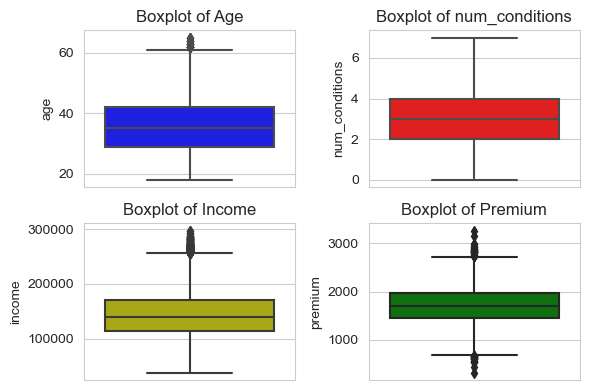

In [264]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_converted_user_navigator['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_converted_user_navigator['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_converted_user_navigator['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_converted_user_navigator['premium'],color='g')
plt.title('Boxplot of Premium')


# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the Converted users through navigator step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at Started_Navigator step

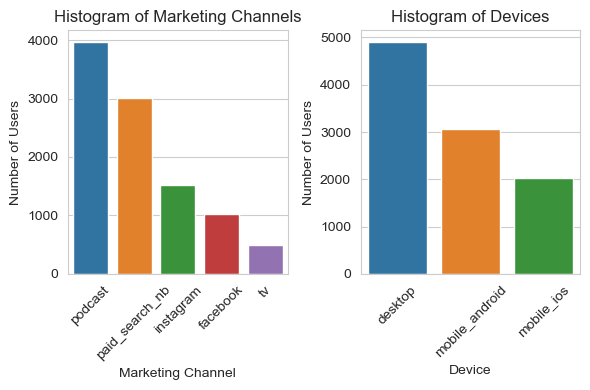

In [265]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_converted_user_navigator, x='marketing_channels', order = df_converted_user_navigator['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_converted_user_navigator, x='device', order = df_converted_user_navigator['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Marketing_challenge percentage at start-navigator step for Converted_Users

In [309]:
# Get the counts of each marketing channel
channel_counts = df_converted_user_navigator['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at started_navigator step')
channel_percentage_df

Marketing_challenge_percentage at started_navigator step


,Marketing Channel,Percentage
0,podcast,39.67
1,paid_search_nb,30.02
2,instagram,15.20
3,facebook,10.21
4,tv,4.90


#### Device percentage at view-quotes step for Converted_Users

In [310]:
# Get the counts of each device
device_counts = df_converted_user_navigator['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at started_navigator step')
device_percentage_df

device_percentage at started_navigator step


,device,Percentage
0,desktop,49.04
1,mobile_android,30.61
2,mobile_ios,20.35


#### Descriptive Statistics of Converted_Users at start-navigator step

In [311]:
# Descriptive Statistics of the features of Converted Users
selected_cols = df_converted_user_navigator[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,35.823800,148238.597900,2.789900,1711.244947
std,9.051052,49631.453214,1.173412,376.764431
min,18.000000,36996.000000,0.000000,315.660679
25%,29.000000,113988.250000,2.000000,1452.091694
50%,35.000000,138684.500000,3.000000,1707.949588
75%,42.000000,171050.000000,4.000000,1966.279246
max,65.000000,297935.000000,7.000000,3267.372222


#### Exploring average-age of converted_users through different marketing channels at started_navigator step

  marketing_channels        age
1          instagram  35.565789
3            podcast  35.722208
0           facebook  35.950049
2     paid_search_nb  36.003331
4                 tv  36.083673


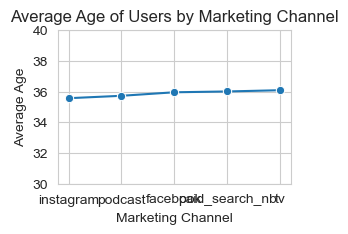

In [268]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_converted_user_navigator.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(3, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Piechart of converted_users in started_navigator step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

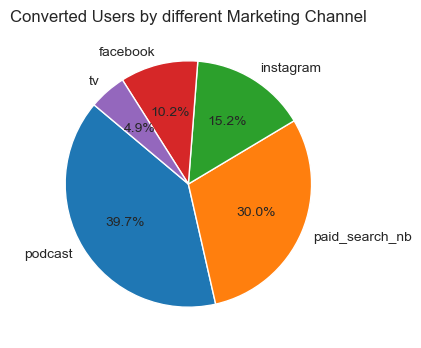

In [313]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_converted_user_navigator['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


# 2.	Collect_contact_info

In [276]:
df_converted_user_collect_contact = merged_df[merged_df['funnel_step_collect_contact_info'] > 0]
df_non_converted_user_collect_contact = merged_df[merged_df['funnel_step_collect_contact_info'] == 0]
df_converted_user_collect_contact.head()

,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue
0,1001,56,desktop,157490,5,2490.123774,instagram,1,1,0,0,0,0,3386.568332
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1,2592.470681
6,1007,55,desktop,157539,4,2237.256580,podcast,1,1,1,0,0,0,3042.668948
8,1009,30,desktop,133151,2,1435.479297,paid_search_nb,1,1,1,1,1,1,1952.251844
9,1010,42,desktop,154022,4,2160.343630,podcast,1,1,0,0,0,0,2938.067336


In [277]:
converted_users_collect_contact_step = df_converted_user_collect_contact.shape[0]
non_converted_users_collect_contact_step = df_non_converted_user_collect_contact.shape[0]
print(f'converted user through the collect contact step is = {converted_users_collect_contact_step}')
print(f'non-converted user through the collect contact step is = {non_converted_users_collect_contact_step}')

converted user through the collect contact step is = 7220
non-converted user through the collect contact step is = 2780


#### boxplot of the features of the Converted users through collect-contact-info step

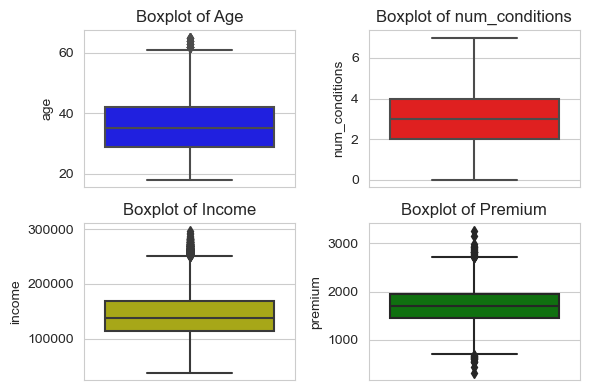

In [136]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_converted_user_collect_contact['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_converted_user_collect_contact['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_converted_user_collect_contact['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_converted_user_collect_contact['premium'],color='g')
plt.title('Boxplot of Premium')


# Display the plots
plt.tight_layout()
plt.show()

#### boxplot of the features of the NON-Converted users through collect-contact-info step

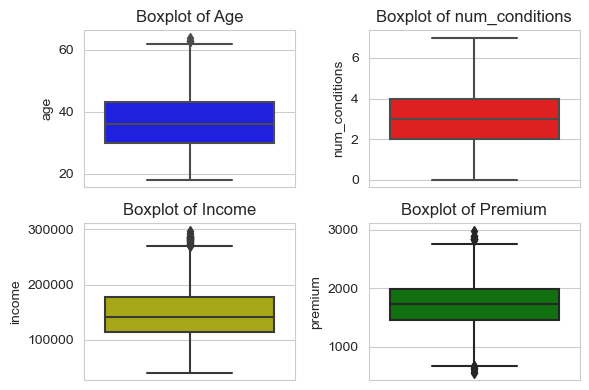

In [137]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_non_converted_user_collect_contact['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_non_converted_user_collect_contact['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_non_converted_user_collect_contact['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_non_converted_user_collect_contact['premium'],color='g')
plt.title('Boxplot of Premium')


# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the Converted users through collect-contact-info step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at collect-contact-info step

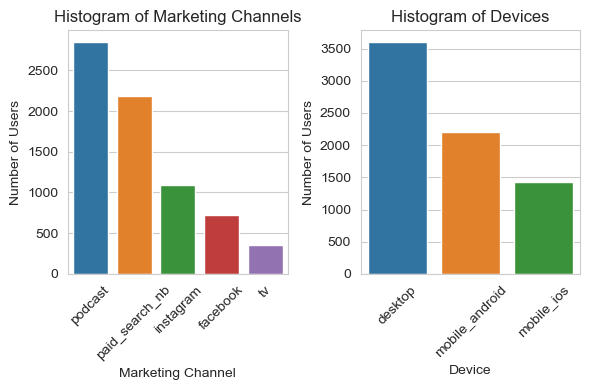

In [138]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_converted_user_collect_contact, x='marketing_channels', order = df_converted_user_collect_contact['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_converted_user_collect_contact, x='device', order = df_converted_user_collect_contact['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the NON_Converted users through collect-contact-info step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at collect-contact-info step

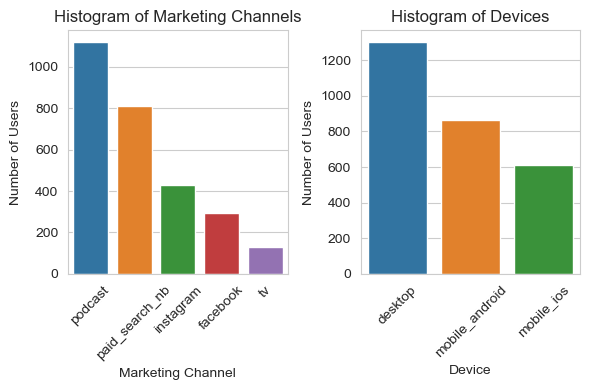

In [139]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_non_converted_user_collect_contact, x='marketing_channels', order = df_non_converted_user_collect_contact['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_non_converted_user_collect_contact, x='device', order = df_non_converted_user_collect_contact['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Marketing_challenge percentage at collect_contact_info step for Converted_Users

In [140]:
# Get the counts of each marketing channel
channel_counts = df_converted_user_collect_contact['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at collect_contact_info step for Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at collect_contact_info step for Converted_Users


,Marketing Channel,Percentage
0,podcast,39.445983
1,paid_search_nb,30.346260
2,instagram,15.138504
3,facebook,10.069252
4,tv,5.000000


#### Marketing_challenge percentage at collect_contact_info step for NON_Converted_Users

In [141]:
# Get the counts of each marketing channel
channel_counts = df_non_converted_user_collect_contact['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at collect_contact_info step for NON_Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at collect_contact_info step for NON_Converted_Users


,Marketing Channel,Percentage
0,podcast,40.251799
1,paid_search_nb,29.172662
2,instagram,15.359712
3,facebook,10.575540
4,tv,4.640288


#### Device percentage at collect_contact_info step for Converted_Users

In [143]:
# Get the counts of each device
device_counts = df_converted_user_collect_contact['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at started_navigator step for converted_users')
device_percentage_df

device_percentage at started_navigator step for converted_users


,device,Percentage
0,desktop,49.889197
1,mobile_android,30.429363
2,mobile_ios,19.681440


#### Device percentage at collect_contact_info step for NON_Converted_Users

In [145]:
# Get the counts of each device
device_counts = df_non_converted_user_collect_contact['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at started_navigator step for non_converted_users')
device_percentage_df

device_percentage at started_navigator step for non_converted_users


,device,Percentage
0,desktop,46.834532
1,mobile_android,31.079137
2,mobile_ios,22.086331


#### Descriptive Statistics of Converted Users at collect_contact_info step


In [146]:
selected_cols = df_converted_user_collect_contact[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,7220.000000,7220.000000,7220.000000,7220.000000
mean,35.585180,147232.196122,2.780748,1706.792850
std,8.994501,48810.927676,1.171647,374.547911
min,18.000000,36996.000000,0.000000,315.660679
25%,29.000000,113742.000000,2.000000,1450.933979
50%,35.000000,137952.500000,3.000000,1703.345891
75%,42.000000,168911.000000,4.000000,1957.139484
max,65.000000,297800.000000,7.000000,3267.372222


#### Descriptive Statistics of NON_Converted Users at collect_contact_info step

In [147]:
selected_cols = df_non_converted_user_collect_contact[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,2780.000000,2780.000000,2780.000000,2780.000000
mean,36.443525,150852.346403,2.813669,1722.807589
std,9.168962,51619.081908,1.177864,382.286828
min,18.000000,40370.000000,0.000000,549.116898
25%,30.000000,114922.500000,2.000000,1456.754359
50%,36.000000,140741.500000,3.000000,1724.325701
75%,43.000000,177213.000000,4.000000,1984.653855
max,64.000000,297935.000000,7.000000,2985.047818


#### Exploring average-age of converted_users through different marketing channels at collect-contact-info step

  marketing_channels        age
1          instagram  35.333943
3            podcast  35.472261
4                 tv  35.587258
2     paid_search_nb  35.695573
0           facebook  36.071527


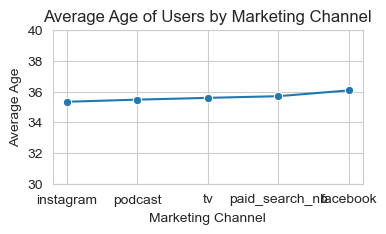

In [272]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_converted_user_collect_contact.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Exploring average-age of NON_converted_users through different marketing channels at collect-contact-info step

  marketing_channels        age
0           facebook  35.649660
1          instagram  36.159251
3            podcast  36.358356
2     paid_search_nb  36.834772
4                 tv  37.472868


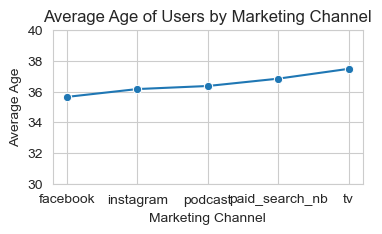

In [150]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_non_converted_user_collect_contact.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Piechart of converted_users in collect_contact_info step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

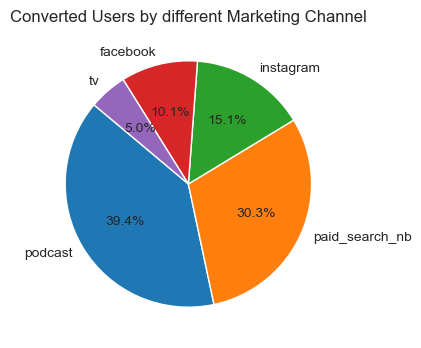

In [151]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_converted_user_collect_contact['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


#### Piechart of NON_converted_users in collect_contact_info step through different marketing channels

Text(0.5, 1.0, 'NON_Converted Users by different Marketing Channel')

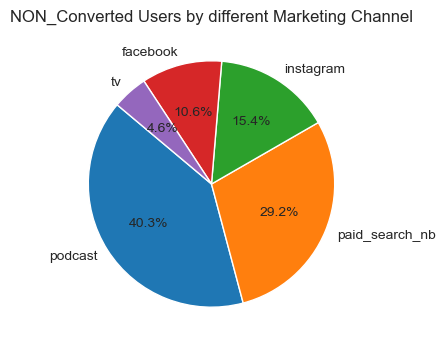

In [184]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_non_converted_user_collect_contact['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('NON_Converted Users by different Marketing Channel')


# 3.	Viewed_quotes  Step

In [279]:
df_converted_user_viewquotes = merged_df[merged_df['funnel_step_viewed_quotes'] > 0]
df_non_converted_user_viewquotes = merged_df[merged_df['funnel_step_viewed_quotes'] == 0]
df_converted_user_viewquotes.head()

,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1,2592.470681
6,1007,55,desktop,157539,4,2237.256580,podcast,1,1,1,0,0,0,3042.668948
8,1009,30,desktop,133151,2,1435.479297,paid_search_nb,1,1,1,1,1,1,1952.251844
10,1011,34,desktop,150797,3,2111.722751,facebook,1,1,1,0,0,0,2871.942942
13,1014,33,desktop,113558,3,1542.074674,facebook,1,1,1,0,0,0,2097.221556


In [280]:
converted_users_viewquote_step = df_converted_user_viewquotes.shape[0]
non_converted_users_viewquote_step = df_non_converted_user_viewquotes.shape[0]
print(f'converted user through the view-quotes step is = {converted_users_viewquote_step}')
print(f'non-converted user through the view-quotes step is = {non_converted_users_viewquote_step}')

converted user through the view-quotes step is = 5245
non-converted user through the view-quotes step is = 4755


#### boxplot of the features of the Converted-users through view-quotes step

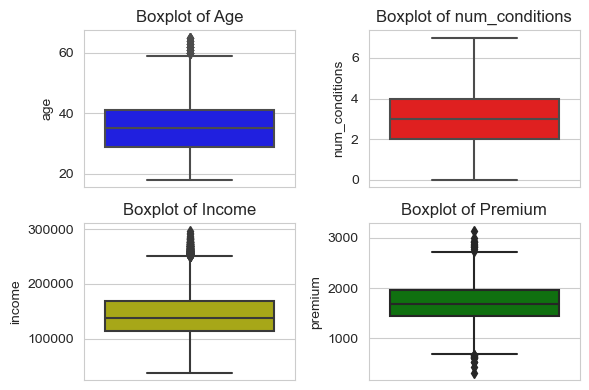

In [157]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_converted_user_viewquotes['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_converted_user_viewquotes['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_converted_user_viewquotes['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_converted_user_viewquotes['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### boxplot of the features of the NON_Converted-users through view-quotes step

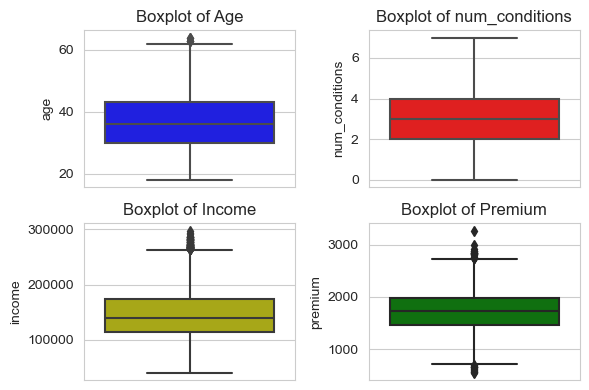

In [158]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_non_converted_user_viewquotes['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_non_converted_user_viewquotes['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_non_converted_user_viewquotes['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 2 row, 2 columns, 4th subplot
sns.boxplot(y=df_non_converted_user_viewquotes['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the Converted_users through view-quotes step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at view-quotes step

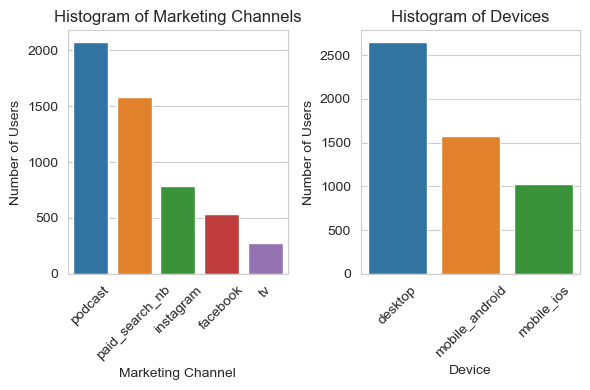

In [159]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_converted_user_viewquotes, x='marketing_channels', order = df_converted_user_viewquotes['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_converted_user_viewquotes, x='device', order = df_converted_user_viewquotes['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the NON_Converted_users through view-quotes step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at view-quotes step

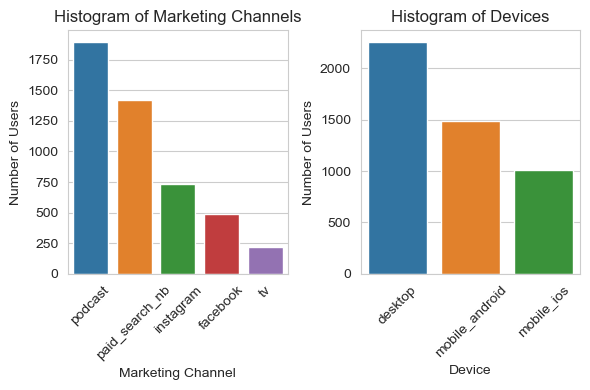

In [160]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6,4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_non_converted_user_viewquotes, x='marketing_channels', order = df_non_converted_user_viewquotes['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_non_converted_user_viewquotes, x='device', order = df_non_converted_user_viewquotes['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Marketing_challenge percentage at view-quotes step for Converted_Users

In [161]:
# Get the counts of each marketing channel
channel_counts = df_converted_user_viewquotes['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at viewquotes step for Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at viewquotes step for Converted_Users


,Marketing Channel,Percentage
0,podcast,39.523356
1,paid_search_nb,30.181125
2,instagram,14.909438
3,facebook,10.181125
4,tv,5.204957


#### Marketing_challenge percentage at view-quotes step for NON_Converted_Users

In [162]:
# Get the counts of each marketing channel
channel_counts = df_non_converted_user_viewquotes['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at viewquotes step for NON_Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at viewquotes step for NON_Converted_Users


,Marketing Channel,Percentage
0,podcast,39.831756
1,paid_search_nb,29.842271
2,instagram,15.520505
3,facebook,10.241851
4,tv,4.563617


#### Device percentage at view_quotes step for Converted_Users

In [163]:
# Get the counts of each device
device_counts = df_converted_user_viewquotes['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at view-quotes step for converted-users')
device_percentage_df

device_percentage at view-quotes step for converted-users


,device,Percentage
0,desktop,50.505243
1,mobile_android,29.933270
2,mobile_ios,19.561487


#### Device percentage at view_quotes step for NON_Converted_Users

In [164]:
# Get the counts of each device
device_counts = df_non_converted_user_viewquotes['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at view-quotes step for NON_converted_users')
device_percentage_df

device_percentage at view-quotes step for NON_converted_users


,device,Percentage
0,desktop,47.423764
1,mobile_android,31.356467
2,mobile_ios,21.219769


#### Descriptive Statistics of Converted_Users at view-quotes step

In [165]:
selected_cols = df_converted_user_viewquotes[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,5245.000000,5245.000000,5245.000000,5245.000000
mean,35.348904,146833.829171,2.778456,1701.413018
std,8.979610,48835.661465,1.169841,376.822060
min,18.000000,36996.000000,0.000000,315.660679
25%,29.000000,113591.000000,2.000000,1442.444749
50%,35.000000,137753.000000,3.000000,1695.073757
75%,41.000000,168610.000000,4.000000,1957.415377
max,65.000000,297800.000000,7.000000,3147.134259


#### Descriptive Statistics of NON_Converted_Users at view-quotes step

In [166]:
selected_cols = df_non_converted_user_viewquotes[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,4755.000000,4755.000000,4755.000000,4755.000000
mean,36.347634,149788.127234,2.802524,1722.090051
std,9.101452,50454.498919,1.177332,376.442691
min,18.000000,40370.000000,0.000000,549.116898
25%,30.000000,114508.500000,2.000000,1465.019909
50%,36.000000,140242.000000,3.000000,1724.830671
75%,43.000000,174193.500000,4.000000,1973.708971
max,64.000000,297935.000000,7.000000,3267.372222


#### Exploring average-age of converted_users through different marketing channels at view_quote step

  marketing_channels        age
1          instagram  35.070332
3            podcast  35.083936
4                 tv  35.564103
2     paid_search_nb  35.608339
0           facebook  35.906367


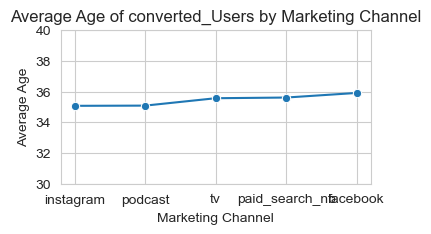

In [174]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_converted_user_viewquotes.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Exploring average-age of NON_converted_users through different marketing channels at view_quote step

  marketing_channels        age
0           facebook  35.997947
1          instagram  36.090786
3            podcast  36.420803
2     paid_search_nb  36.443975
4                 tv  36.737327


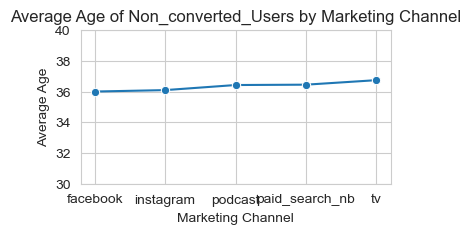

In [176]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_non_converted_user_viewquotes.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of Non_converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Piechart of converted_users in view-quotes step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

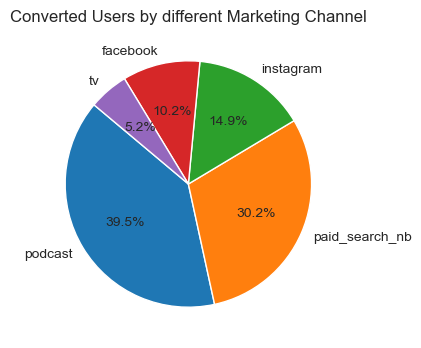

In [182]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_converted_user_viewquotes['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


#### Piechart of NON_converted_users in view-quotes step through different marketing channels

Text(0.5, 1.0, 'NON_Converted Users by different Marketing Channel')

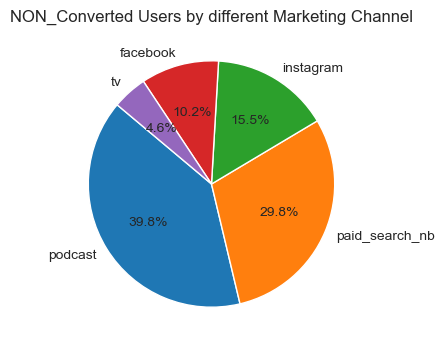

In [183]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_non_converted_user_viewquotes['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4,4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('NON_Converted Users by different Marketing Channel')


# 4.	Application_submit step

In [187]:
df_converted_user_appsubmit = merged_df[merged_df['funnel_step_application_submit'] > 0]
df_non_converted_user_appsubmit = merged_df[merged_df['funnel_step_application_submit'] == 0]
df_converted_user_appsubmit.head()

,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1,2592.470681
8,1009,30,desktop,133151,2,1435.479297,paid_search_nb,1,1,1,1,1,1,1952.251844
14,1015,30,desktop,132164,2,1514.782822,instagram,1,1,1,1,0,0,2060.104638
15,1016,47,desktop,165372,4,2483.251251,paid_search_nb,1,1,1,1,1,0,3377.221701
20,1021,39,desktop,118541,2,1443.764269,instagram,1,1,1,1,1,0,1963.519405


In [188]:
converted_users_appsubmit_step = df_converted_user_appsubmit.shape[0]
non_converted_users_appsubmit_step = df_non_converted_user_appsubmit.shape[0]
print(f'converted user through the application-submit step is = {converted_users_appsubmit_step}')
print(f'non-converted user through the application-submit step is = {non_converted_users_appsubmit_step}')

converted user through the application-submit step is = 2855
non-converted user through the application-submit step is = 7145


#### boxplot of the features of the Converted-users through application-submit step

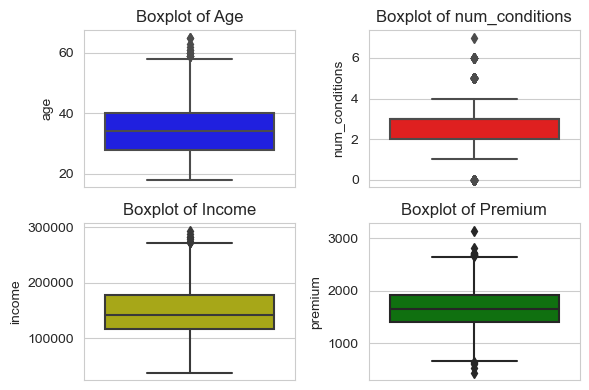

In [189]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_converted_user_appsubmit['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_converted_user_appsubmit['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_converted_user_appsubmit['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_converted_user_appsubmit['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### boxplot of the features of the NON_Converted-users through application-submit step

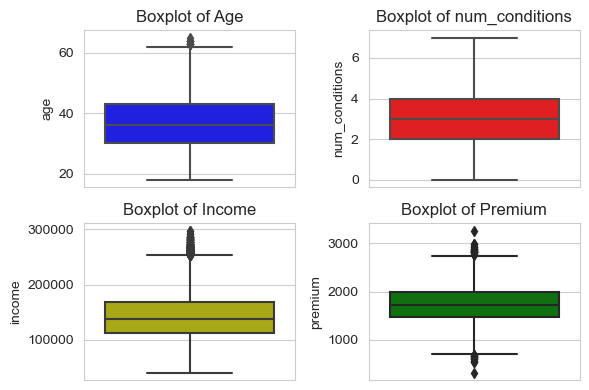

In [190]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_non_converted_user_appsubmit['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_non_converted_user_appsubmit['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_non_converted_user_appsubmit['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_non_converted_user_appsubmit['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the Converted_users through application-submit step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at application_submit step

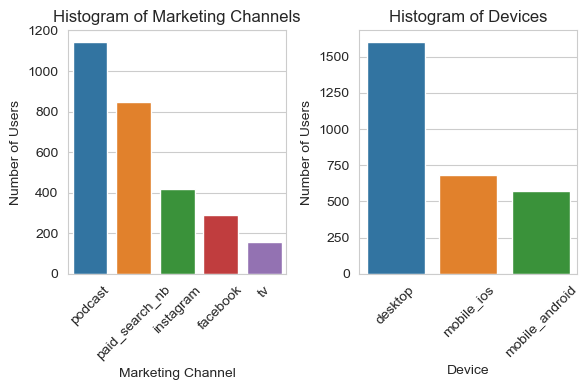

In [192]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_converted_user_appsubmit, x='marketing_channels', order = df_converted_user_appsubmit['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_converted_user_appsubmit, x='device', order = df_converted_user_appsubmit['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the NON_Converted_users through application-submit step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at application_submit step

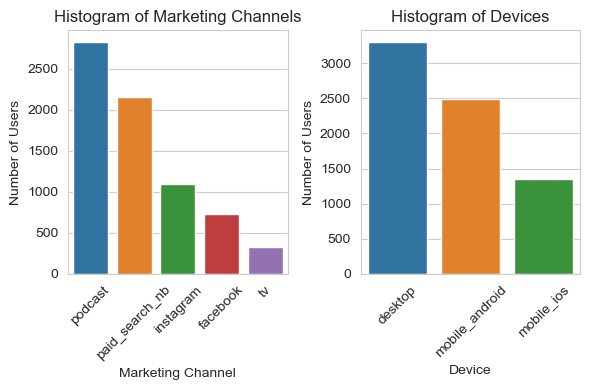

In [194]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_non_converted_user_appsubmit, x='marketing_channels', order = df_non_converted_user_appsubmit['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_non_converted_user_appsubmit, x='device', order = df_non_converted_user_appsubmit['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Marketing_challenge percentage at application-submit step for Converted_Users

In [195]:
# Get the counts of each marketing channel
channel_counts = df_converted_user_appsubmit['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at application-submit step for Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at application-submit step for Converted_Users


,Marketing Channel,Percentage
0,podcast,40.035026
1,paid_search_nb,29.667250
2,instagram,14.676007
3,facebook,10.087566
4,tv,5.534151


#### Marketing_challenge percentage at application-submit step for NON_Converted_Users

In [196]:
# Get the counts of each marketing channel
channel_counts = df_non_converted_user_appsubmit['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at application-submit step for NON_Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at application-submit step for NON_Converted_Users


,Marketing Channel,Percentage
0,podcast,39.524143
1,paid_search_nb,30.160952
2,instagram,15.409377
3,facebook,10.258922
4,tv,4.646606


#### Device percentage at application-submit step for Converted_Users

In [198]:
# Get the counts of each device
device_counts = df_converted_user_appsubmit['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at application_submit step for converted-users')
device_percentage_df

device_percentage at application_submit step for converted-users


,device,Percentage
0,desktop,56.077058
1,mobile_ios,23.992995
2,mobile_android,19.929947


#### Device percentage at application-submit step for NON_Converted_Users

In [199]:
# Get the counts of each device
device_counts = df_non_converted_user_appsubmit['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at application-submit step for NON_converted-users')
device_percentage_df

device_percentage at application-submit step for NON_converted-users


,device,Percentage
0,desktop,46.228132
1,mobile_android,34.877537
2,mobile_ios,18.894332


#### Descriptive Statistics of Converted_Users at application_submit step

In [200]:
selected_cols = df_converted_user_appsubmit[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,2855.000000,2855.000000,2855.000000,2855.000000
mean,34.014011,151354.769177,2.609457,1662.738832
std,8.660607,50319.865346,1.163800,373.883940
min,18.000000,36996.000000,0.000000,437.422111
25%,28.000000,116255.000000,2.000000,1414.509178
50%,34.000000,141011.000000,3.000000,1660.399491
75%,40.000000,178116.500000,3.000000,1913.138465
max,65.000000,294056.000000,7.000000,3147.134259


#### Descriptive Statistics of NON_Converted_Users at application_submit step

In [201]:
selected_cols = df_non_converted_user_appsubmit[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,7145.000000,7145.000000,7145.000000,7145.000000
mean,36.546956,146993.437789,2.862001,1730.627027
std,9.102952,49302.192950,1.169552,376.190261
min,18.000000,40370.000000,0.000000,315.660679
25%,30.000000,113332.000000,2.000000,1474.145874
50%,36.000000,137475.000000,3.000000,1727.846185
75%,43.000000,169217.000000,4.000000,1984.445391
max,65.000000,297935.000000,7.000000,3267.372222


#### Exploring average-age of converted_users through different marketing channels at application-submit step

  marketing_channels        age
1          instagram  33.754177
3            podcast  33.930009
2     paid_search_nb  34.083825
0           facebook  34.302083
4                 tv  34.411392


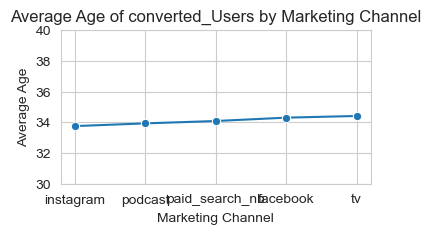

In [202]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_converted_user_appsubmit.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Exploring average-age of NON_converted_users through different marketing channels at application_submit step

  marketing_channels        age
1          instagram  36.255223
3            podcast  36.447592
0           facebook  36.597544
2     paid_search_nb  36.757773
4                 tv  36.879518


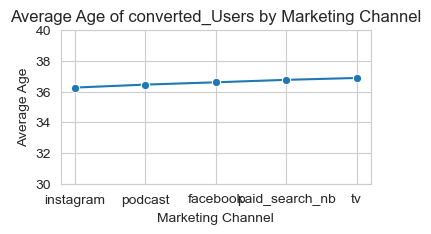

In [203]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_non_converted_user_appsubmit.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Piechart of converted_users in application-submit step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

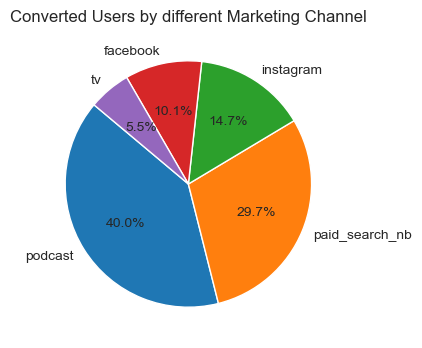

In [206]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_converted_user_appsubmit['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


#### Piechart of converted_users in application-submit step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

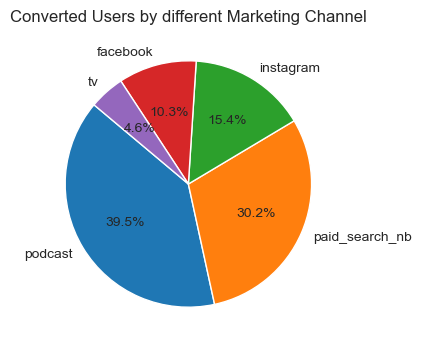

In [207]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_non_converted_user_appsubmit['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


# 5.	Phone_connect Step 

In [210]:
df_converted_user_phoneconnect = merged_df[merged_df['funnel_step_phone_connect'] > 0]
df_non_converted_user_phoneconnect = merged_df[merged_df['funnel_step_phone_connect'] == 0]
df_converted_user_phoneconnect.head()

,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1,2592.470681
8,1009,30,desktop,133151,2,1435.479297,paid_search_nb,1,1,1,1,1,1,1952.251844
15,1016,47,desktop,165372,4,2483.251251,paid_search_nb,1,1,1,1,1,0,3377.221701
20,1021,39,desktop,118541,2,1443.764269,instagram,1,1,1,1,1,0,1963.519405
22,1023,52,desktop,190045,5,2520.282072,paid_search_nb,1,1,1,1,1,0,3427.583617


In [211]:
converted_users_phoneconnect_step = df_converted_user_phoneconnect.shape[0]
non_converted_users_phoneconnect_step = df_non_converted_user_phoneconnect.shape[0]
print(f'converted user through the phone-connect step is = {converted_users_phoneconnect_step}')
print(f'non-converted user through the phone-connect step is = {non_converted_users_phoneconnect_step}')

converted user through the phone-connect step is = 1525
non-converted user through the phone-connect step is = 8475


#### boxplot of the features of the Converted-users through phone-connected step

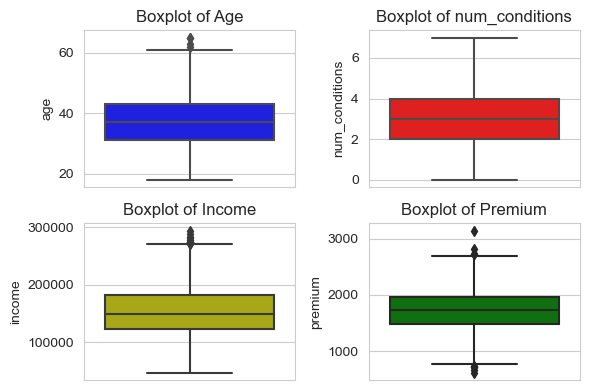

In [212]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_converted_user_phoneconnect['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_converted_user_phoneconnect['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_converted_user_phoneconnect['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_converted_user_phoneconnect['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### boxplot of the features of the NON_Converted-users through phone-connected step

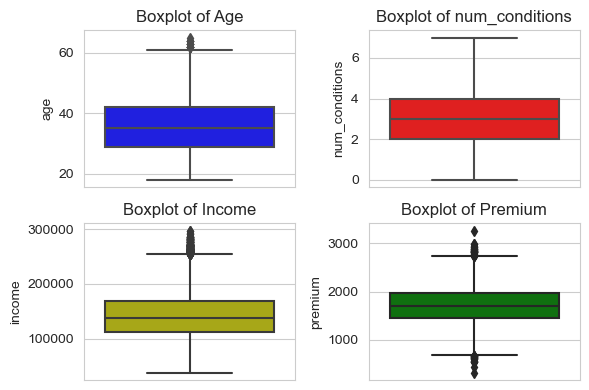

In [213]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_non_converted_user_phoneconnect['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_non_converted_user_phoneconnect['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_non_converted_user_phoneconnect['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_non_converted_user_phoneconnect['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the Converted_users through phone-connect step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at phone-connect step

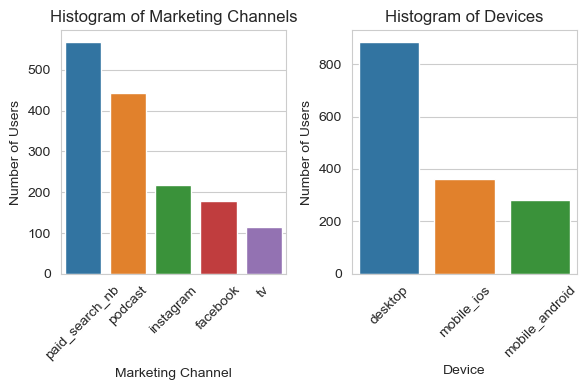

In [217]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_converted_user_phoneconnect, x='marketing_channels', order = df_converted_user_phoneconnect['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_converted_user_phoneconnect, x='device', order = df_converted_user_phoneconnect['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the NON_Converted_users through phone-connect step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at phone-connect step

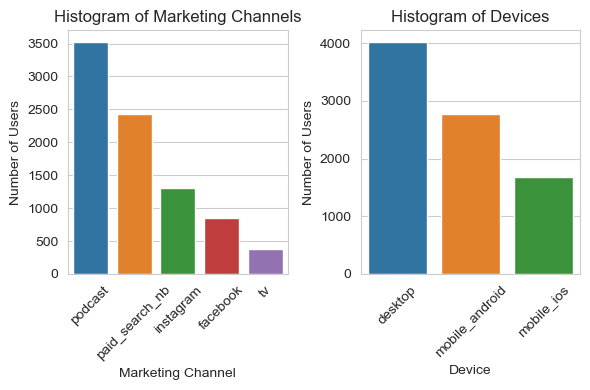

In [216]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_non_converted_user_phoneconnect, x='marketing_channels', order = df_non_converted_user_phoneconnect['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_non_converted_user_phoneconnect, x='device', order = df_non_converted_user_phoneconnect['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Marketing_challenge percentage at phone-connect step for Converted_Users

In [218]:
# Get the counts of each marketing channel
channel_counts = df_converted_user_phoneconnect['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at phone-connect step for Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at phone-connect step for Converted_Users


,Marketing Channel,Percentage
0,paid_search_nb,37.245902
1,podcast,29.114754
2,instagram,14.295082
3,facebook,11.737705
4,tv,7.606557


In [219]:
#### Marketing_challenge percentage at phone-connect step for NON_Converted_Users

In [221]:
# Get the counts of each marketing channel
channel_counts = df_non_converted_user_phoneconnect['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at phone-connect step for NON_Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at phone-connect step for NON_Converted_Users


,Marketing Channel,Percentage
0,podcast,41.569322
1,paid_search_nb,28.719764
2,instagram,15.362832
3,facebook,9.935103
4,tv,4.412979


#### Device percentage at phone-connect step for Converted_Users

In [223]:
# Get the counts of each device
device_counts = df_converted_user_phoneconnect['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at phone connect step for converted-users')
device_percentage_df

device_percentage at phone connect step for converted-users


,device,Percentage
0,desktop,57.967213
1,mobile_ios,23.606557
2,mobile_android,18.426230


#### Device percentage at phone-connect step for NON_Converted_Users

In [225]:
# Get the counts of each device
device_counts = df_non_converted_user_phoneconnect['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at phone-connect step for NON_converted-users')
device_percentage_df

device_percentage at phone-connect step for NON_converted-users


,device,Percentage
0,desktop,47.433628
1,mobile_android,32.802360
2,mobile_ios,19.764012


#### Descriptive Statistics of Converted_Users at phone-connect step

In [226]:
selected_cols = df_converted_user_phoneconnect[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,1525.000000,1525.000000,1525.000000,1525.000000
mean,37.408525,158469.584918,2.746885,1734.041725
std,8.452915,49478.987647,1.152510,368.745807
min,18.000000,47005.000000,0.000000,611.156039
25%,31.000000,123552.000000,2.000000,1483.522570
50%,37.000000,148605.000000,3.000000,1731.811934
75%,43.000000,182349.000000,4.000000,1972.116855
max,65.000000,294056.000000,7.000000,3147.134259


#### Descriptive Statistics of NON_Converted_Users at phone-connect step

In [228]:
selected_cols = df_non_converted_user_phoneconnect[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,8475.000000,8475.000000,8475.000000,8475.000000
mean,35.538643,146397.623835,2.797640,1707.142872
std,9.125835,49437.462098,1.177034,378.064725
min,18.000000,36996.000000,0.000000,315.660679
25%,29.000000,112508.000000,2.000000,1446.925178
50%,35.000000,136796.000000,3.000000,1703.903665
75%,42.000000,169283.000000,4.000000,1964.306412
max,65.000000,297935.000000,7.000000,3267.372222


#### Exploring average-age of converted_users through different marketing channels at phone-connect step

  marketing_channels        age
2     paid_search_nb  36.596831
4                 tv  36.706897
0           facebook  36.810056
1          instagram  37.573394
3            podcast  38.790541


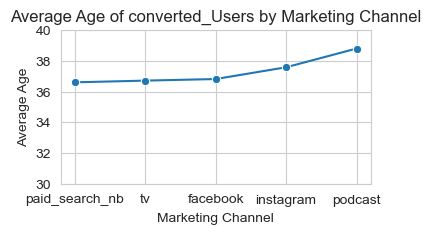

In [229]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_converted_user_phoneconnect.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Exploring average-age of NON_converted_users through different marketing channels at phone-connect step

  marketing_channels        age
1          instagram  35.229647
3            podcast  35.335510
0           facebook  35.767221
2     paid_search_nb  35.864832
4                 tv  35.890374


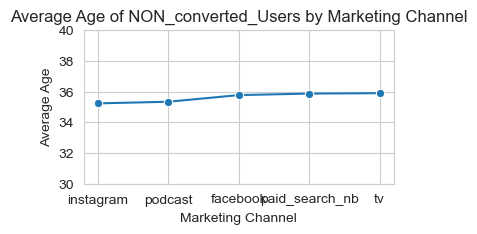

In [230]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_non_converted_user_phoneconnect.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of NON_converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Piechart of converted_users in phone-connect step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

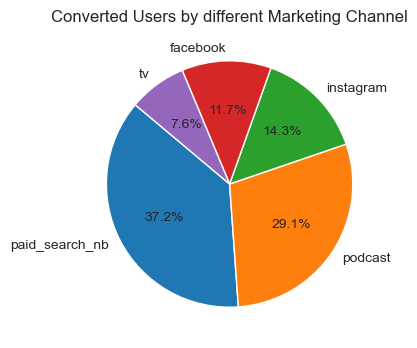

In [231]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_converted_user_phoneconnect['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


#### Piechart of NON_converted_users in phone-connect step through different marketing channels

Text(0.5, 1.0, 'NON-Converted-Users by different Marketing Channel')

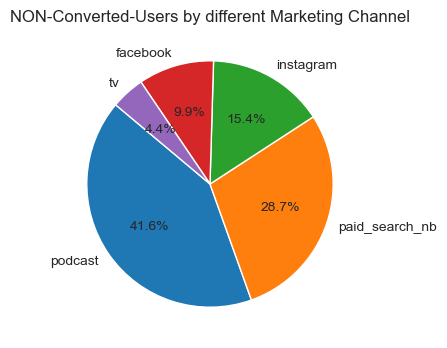

In [233]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_non_converted_user_phoneconnect['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('NON-Converted-Users by different Marketing Channel')


# 6.	Sign_and_exam Step

In [234]:
df_converted_user_signexam = merged_df[merged_df['funnel_step_sign_and_exam'] > 0]
df_non_converted_user_signexam = merged_df[merged_df['funnel_step_sign_and_exam'] == 0]
df_converted_user_signexam.head()

,user_id,age,device,income,num_conditions,premium,marketing_channels,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb,1,1,1,1,1,1,2592.470681
8,1009,30,desktop,133151,2,1435.479297,paid_search_nb,1,1,1,1,1,1,1952.251844
27,1028,28,desktop,130212,2,914.126760,paid_search_nb,1,1,1,1,1,1,1243.212393
45,1046,23,desktop,126756,1,1205.959698,podcast,1,1,1,1,1,1,1640.105190
46,1047,43,desktop,167445,4,2001.268365,podcast,1,1,1,1,1,1,2721.724977


In [235]:
converted_users_signexam_step = df_converted_user_signexam.shape[0]
non_converted_users_signexam_step = df_non_converted_user_signexam.shape[0]
print(f'converted user through the sign-exam step is = {converted_users_signexam_step}')
print(f'non-converted user through the sign-exam step is = {non_converted_users_signexam_step}')

converted user through the sign-exam step is = 784
non-converted user through the sign-exam step is = 9216


#### boxplot of the features of the Converted-users through sign-exam step

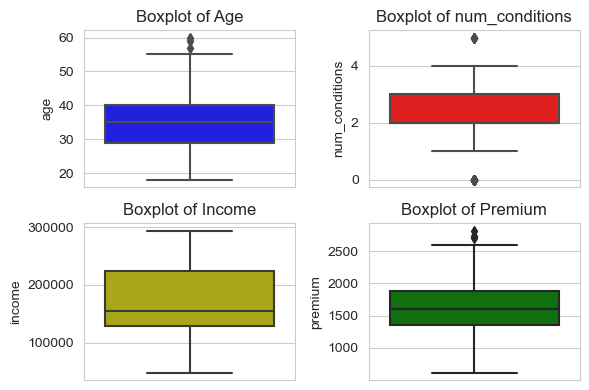

In [236]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_converted_user_signexam['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_converted_user_signexam['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_converted_user_signexam['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_converted_user_signexam['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### boxplot of the features of the NON_Converted-users through sign-exam step

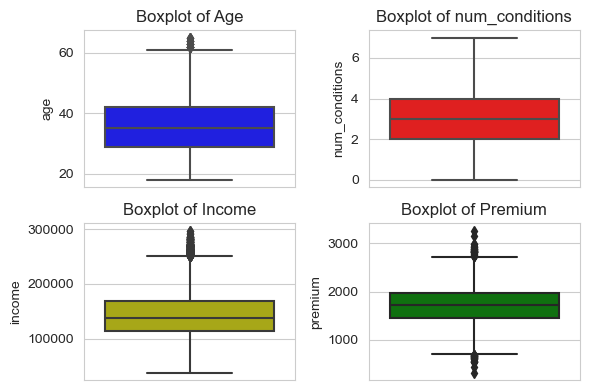

In [237]:
# Creating a figure for the boxplots
plt.figure(figsize=(6, 4))

# Creating a boxplot for the 'age' feature
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.boxplot(y=df_non_converted_user_signexam['age'],color='b')
plt.title('Boxplot of Age')

# Creating a boxplot for the 'num_conditions' feature
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.boxplot(y=df_non_converted_user_signexam['num_conditions'],color='r')
plt.title('Boxplot of num_conditions')


# Creating a boxplot for the 'income' feature
plt.subplot(2, 2, 3)  # 2 row, 2 columns, 3rd subplot
sns.boxplot(y=df_non_converted_user_signexam['income'],color='y')
plt.title('Boxplot of Income')

# Creating a boxplot for the 'premium' feature
plt.subplot(2, 2, 4)  # 1 row, 2 columns, 4th subplot
sns.boxplot(y=df_non_converted_user_signexam['premium'],color='g')
plt.title('Boxplot of Premium')

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the Converted_users through sign-exam step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at sign-exam step

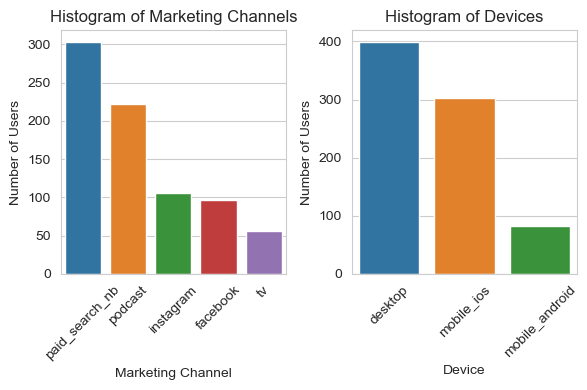

In [238]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_converted_user_signexam, x='marketing_channels', order = df_converted_user_signexam['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_converted_user_signexam, x='device', order = df_converted_user_signexam['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Histogram analysis of the NON_Converted_users through sign-exam step
Plot the histogram(distribusion) of our categorical features (device, marketing_channel) at sign-exam step

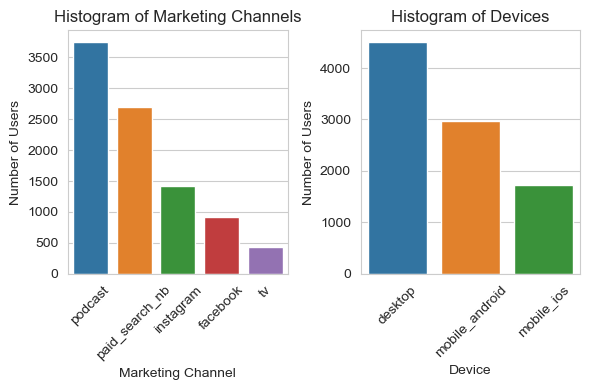

In [239]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure for the histograms
plt.figure(figsize=(6, 4))

# Creating a histogram for the 'marketing_channel' feature
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(data=df_non_converted_user_signexam, x='marketing_channels', order = df_non_converted_user_signexam['marketing_channels'].value_counts().index)
plt.title('Histogram of Marketing Channels')
plt.xlabel('Marketing Channel')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Creating a histogram for the 'device' feature
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(data=df_non_converted_user_signexam, x='device', order = df_non_converted_user_signexam['device'].value_counts().index)
plt.title('Histogram of Devices')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate the x labels for better readability

# Display the plots
plt.tight_layout()
plt.show()

#### Marketing_challenge percentage at sign-exam step for Converted_Users

In [240]:
# Get the counts of each marketing channel
channel_counts = df_converted_user_signexam['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at sign-exam step for Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at sign-exam step for Converted_Users


,Marketing Channel,Percentage
0,paid_search_nb,38.647959
1,podcast,28.316327
2,instagram,13.520408
3,facebook,12.372449
4,tv,7.142857


#### Marketing_challenge percentage at sign-exam step for NON_Converted_Users

In [242]:
# Get the counts of each marketing channel
channel_counts = df_non_converted_user_signexam['marketing_channels'].value_counts()

# Normalize the counts to get the percentage
channel_percentage = channel_counts / channel_counts.sum() * 100

channel_percentage_df = channel_percentage.reset_index()
channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Display the percentage of users for each marketing channel
print('Marketing_challenge_percentage at sign-exam step for NON_Converted_Users')
channel_percentage_df

Marketing_challenge_percentage at sign-exam step for NON_Converted_Users


,Marketing Channel,Percentage
0,podcast,40.635851
1,paid_search_nb,29.286024
2,instagram,15.342882
3,facebook,10.026042
4,tv,4.709201


#### Device percentage at sign-exam step for Converted_Users

In [243]:
# Get the counts of each device
device_counts = df_converted_user_signexam['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at sign-exam step for converted-users')
device_percentage_df

device_percentage at sign-exam step for converted-users


,device,Percentage
0,desktop,50.892857
1,mobile_ios,38.647959
2,mobile_android,10.459184


#### Device percentage at sign-exam step for NON_Converted_Users

In [244]:
# Get the counts of each device
device_counts = df_non_converted_user_signexam['device'].value_counts()

# Normalize the counts to get the percentage
device_percentage = device_counts / device_counts.sum() * 100

device_percentage_df = device_percentage.reset_index()
device_percentage_df.columns = ['device', 'Percentage']

# Display the percentage of users for each marketing channel
print('device_percentage at sign-exam step for NON_converted-users')
device_percentage_df

device_percentage at sign-exam step for NON_converted-users


,device,Percentage
0,desktop,48.882378
1,mobile_android,32.324219
2,mobile_ios,18.793403


#### Descriptive Statistics of Converted_Users at sign-exam step

In [245]:
selected_cols = df_converted_user_signexam[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,784.000000,784.000000,784.000000,784.000000
mean,34.674745,170853.100765,2.164541,1615.719846
std,7.978744,54936.033560,1.005587,371.402446
min,18.000000,47873.000000,0.000000,611.156039
25%,29.000000,128862.000000,2.000000,1351.700937
50%,35.000000,154932.500000,2.000000,1605.745767
75%,40.000000,224997.500000,3.000000,1878.620881
max,60.000000,294056.000000,5.000000,2818.132795


#### Descriptive Statistics of NON_Converted_Users at sign-exam step

In [246]:
selected_cols = df_non_converted_user_signexam[['age','income','num_conditions','premium']]
selected_cols.describe()

,age,income,num_conditions,premium
count,9216.000000,9216.000000,9216.000000,9216.000000
mean,35.921549,146314.794705,2.843099,1719.371215
std,9.130181,48674.476424,1.171331,376.118761
min,18.000000,36996.000000,0.000000,315.660679
25%,29.000000,113197.750000,2.000000,1462.067341
50%,35.000000,137521.500000,3.000000,1716.719238
75%,42.000000,168190.500000,4.000000,1972.065805
max,65.000000,297935.000000,7.000000,3267.372222


#### Exploring average-age of converted_users through different marketing channels at sign-exam step

  marketing_channels        age
2     paid_search_nb  33.534653
4                 tv  34.178571
0           facebook  34.659794
1          instagram  34.849057
3            podcast  36.279279


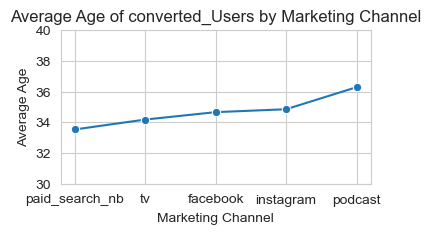

In [247]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_converted_user_signexam.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Exploring average-age of NON_converted_users through different marketing channels at sign-exam step

  marketing_channels        age
1          instagram  35.619519
3            podcast  35.689186
0           facebook  36.085498
2     paid_search_nb  36.280474
4                 tv  36.329493


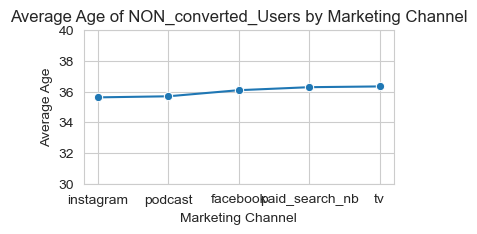

In [248]:
# Calculate the average age for users who saw the ad through different marketing channels
average_age_per_channel = df_non_converted_user_signexam.groupby('marketing_channels')['age'].mean().reset_index()

# Sort the results for better visualization
average_age_per_channel = average_age_per_channel.sort_values(by='age')
print(average_age_per_channel)

# Visualize the results
plt.figure(figsize=(4, 2))
sns.lineplot(data=average_age_per_channel, x='marketing_channels', y='age', marker='o')
plt.title('Average Age of NON_converted_Users by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Average Age')
plt.ylim(30, 40)
plt.xticks(rotation=0)  # Rotate the labels for better readability
plt.show()


#### Piechart of converted_users in sign-exam step through different marketing channels

Text(0.5, 1.0, 'Converted Users by different Marketing Channel')

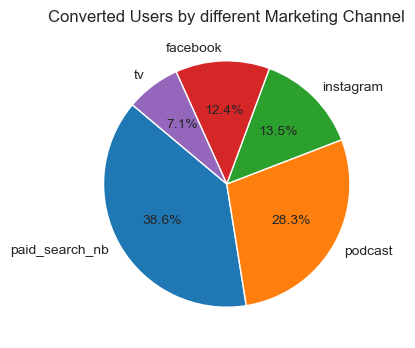

In [249]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_converted_user_signexam['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('Converted Users by different Marketing Channel')


#### Piechart of NON_converted_users in sign-exam step through different marketing channels

Text(0.5, 1.0, 'NON_Converted Users by different Marketing Channel')

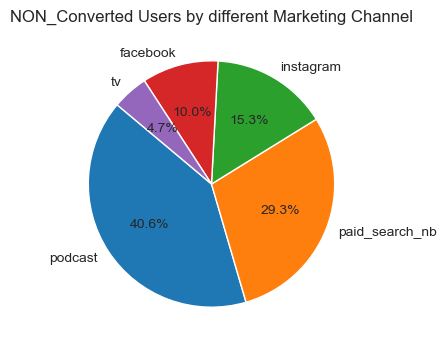

In [250]:
# Calculate the percentage of converted users for each marketing channel
converted_channel_counts = df_non_converted_user_signexam['marketing_channels'].value_counts()
converted_channel_percentage = converted_channel_counts / converted_channel_counts.sum() * 100

# Convert to DataFrame for easier handling
converted_channel_percentage_df = converted_channel_percentage.reset_index()
converted_channel_percentage_df.columns = ['Marketing Channel', 'Percentage']

# Draw a pie chart
plt.figure(figsize=(4, 4))
plt.pie(converted_channel_percentage_df['Percentage'], labels=converted_channel_percentage_df['Marketing Channel'], autopct='%1.1f%%', startangle=140)
plt.title('NON_Converted Users by different Marketing Channel')


## GENERAL VISUALISATION THROUGH THE WHOLE FUNNEL

#### Visualising the conversion-rate of users who made it through the last step pf the funnel "sign_and_exam" 

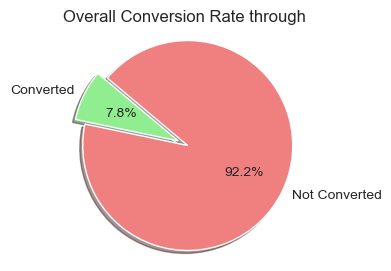

In [311]:
# Filter users who converted and who didn't convert at the 'funnel_step_sign_and_exam'
converted_users = df_converted_user_signexam.shape[0]
non_converted_users = df_non_converted_user_signexam.shape[0]

# Assuming all users initially see the ad at 'funnel_step_started_navigator' step
initial_users = merged_df.shape[0]

# Calculate conversion rates
conversion_rate_converted_user = (converted_users / initial_users) * 100
conversion_rate_non_converted_user = (non_converted_users / initial_users) * 100

# Data to plot
labels = 'Converted', 'Not Converted'
sizes = [conversion_rate_converted_user, conversion_rate_non_converted_user]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(3, 3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Overall Conversion Rate through')
plt.show()


#### Conversion-rate & user-reduction through the funnel

In [301]:
# Calculate the number of users at each funnel step
# Which in our merged_df the last 6 columns are hot-encoded funnel steps
num_users_at_each_step = merged_df.iloc[:, -6:].sum()
step_to_step_conversion_rates = (num_users_at_each_step / num_users_at_each_step.shift(1) * 100).fillna(0)
reduction_numbers = num_users_at_each_step.diff().fillna(0)

# Calculate the reduction percentage (ignoring the first step as it has no previous step)
reduction_percentage = abs(reduction_numbers / num_users_at_each_step.shift(1) * 100)

# Fill NaN values (which occur for the first step) with 0
reduction_percentage = reduction_percentage.fillna(0)

conversion_rate_df = pd.DataFrame({
    'funnel_steps': num_users_at_each_step.index,
    'number-of-users-per-step' : num_users_at_each_step.values,
    'step_to_step_conversion_rate': step_to_step_conversion_rates.values,
    'users_reduction_percentage' : reduction_percentage.values
})
# Display the result
conversion_rate_df

,funnel_steps,number-of-users-per-step,step_to_step_conversion_rate,users_reduction_percentage
0,funnel_step_viewed_quotes,5.245000e+03,0.000000e+00,0.000000e+00
1,funnel_step_application_submit,2.855000e+03,5.443279e+01,4.556721e+01
2,funnel_step_phone_connect,1.525000e+03,5.341506e+01,4.658494e+01
3,funnel_step_sign_and_exam,7.840000e+02,5.140984e+01,4.859016e+01
4,revenue,2.327293e+07,2.968486e+06,2.968386e+06


- A conversion rate records the percentage of users who have completed a desired action
- reduction percentage shows the percentage drop between each step compared to the previous step.
- At the first_level of the funnel(started_navigator), 10,000 unique users see the adds through different marketing channels.
- We can see that we have 27% user drop-off at collect_contact_info step. It means almost 73 % of users convert from started_navigator to collect_info step.(we can say good number of users got interested to the adds and went through the second step)
- The large user drop_off at application_submit is considerable. It means almost half of the user after viewed_quotes step stopeed their action and didn't move through application_submitted.
- This dropp of can have different reasons. It might be because of the price of insurance plan are high and people with low income don't move forward to the next steps. (we will investigate later)
- Another reason might be the age of the users (they are eldery people) and it's not easy for them to submit the applications (we will investigate later)

#### Average-age of users in both the "funnel_step_viewed_quotes" and "funnel_step_application_submit" funnel steps

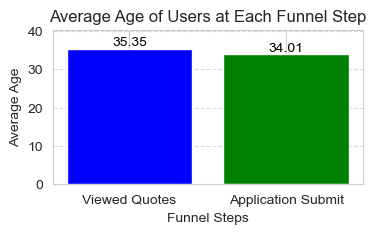

In [303]:
# Filter users who reached each funnel step
users_viewed_quotes = merged_df[merged_df['funnel_step_viewed_quotes'] > 0]
users_application_submit = merged_df[merged_df['funnel_step_application_submit'] > 0]

# Calculate the average age for each step
avg_age_viewed_quotes = users_viewed_quotes['age'].mean()
avg_age_application_submit = users_application_submit['age'].mean()

# Prepare data for visualization
steps = ['Viewed Quotes', 'Application Submit']
avg_ages = [avg_age_viewed_quotes, avg_age_application_submit]

# Create bar plot
plt.figure(figsize=(4, 2))
bars = plt.bar(steps, avg_ages, color=['blue', 'green'])
plt.title('Average Age of Users at Each Funnel Step')
plt.xlabel('Funnel Steps')
plt.ylabel('Average Age')
plt.ylim([0, max(avg_ages) + 5])  # Set y-axis limit slightly higher than max avg age for better visualization
plt.xticks(steps)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the value of each average age on the plot
for bar, age in zip(bars, avg_ages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{age:.2f}', 
             ha='center', va='bottom', color='black', fontsize=10)

# Display the plot
plt.show()


- We can see the range of the people at both "viewed quotes" and "Application Submit" are the same between 34-35 years oild. So the hypothesis that the maybe tha average age of people are high between these 2 funnel steps is wrong.

#### Display the scatterplot of the Income vs. Premium at Application-Submit Step and Viewed Quotes Step

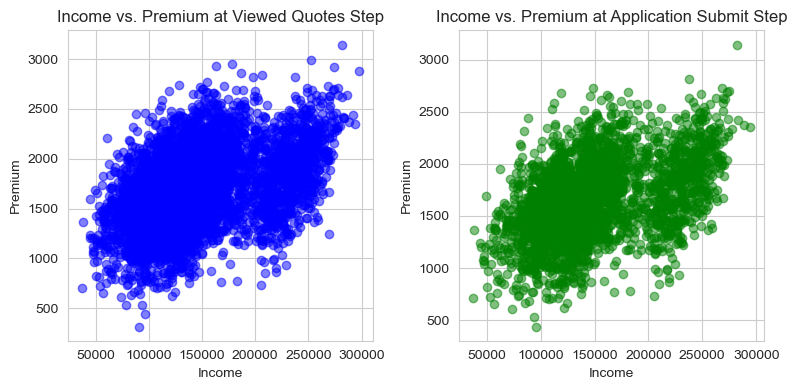

In [308]:
# Set the figure size and create subplots
plt.figure(figsize=(8, 4))

# Scatter plot for users at 'funnel_step_viewed_quotes'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(users_viewed_quotes['income'], users_viewed_quotes['premium'], alpha=0.5, color='blue')
plt.title('Income vs. Premium at Viewed Quotes Step')
plt.xlabel('Income')
plt.ylabel('Premium')
plt.grid(True)

# Scatter plot for users at 'funnel_step_application_submit'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(users_application_submit['income'], users_application_submit['premium'], alpha=0.5, color='green')
plt.title('Income vs. Premium at Application Submit Step')
plt.xlabel('Income')
plt.ylabel('Premium')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [309]:
#### Correletaion between Income and Premium

In [310]:
# 1. Calculate Correlation
corr_viewed_quotes = users_viewed_quotes[['income', 'premium']].corr()
corr_application_submit = users_application_submit[['income', 'premium']].corr()

# 2. Compare Average Drop-off
avg_income_premium_viewed_quotes = users_viewed_quotes[['income', 'premium']].mean()
avg_income_premium_application_submit = users_application_submit[['income', 'premium']].mean()

# Display the results
print("Correlation at 'Viewed Quotes' Step:\n", corr_viewed_quotes)
print("\nCorrelation at 'Application Submit' Step:\n", corr_application_submit)
print("\nAverage Income and Premium at 'Viewed Quotes' Step:\n", avg_income_premium_viewed_quotes)
print("\nAverage Income and Premium at 'Application Submit' Step:\n", avg_income_premium_application_submit)


Correlation at 'Viewed Quotes' Step:
            income   premium
income   1.000000  0.434697
premium  0.434697  1.000000

Correlation at 'Application Submit' Step:
            income   premium
income   1.000000  0.449789
premium  0.449789  1.000000

Average Income and Premium at 'Viewed Quotes' Step:
 income     146833.829171
premium      1701.413018
dtype: float64

Average Income and Premium at 'Application Submit' Step:
 income     151354.769177
premium      1662.738832
dtype: float64


- The Average Income at 'Viewed Quotes' Step is 146,833 CAD and the premium(the annual price for the lowest policy from the quotes provided to customers) is 1701, However the Average Income at 'Application Submit' Step is 151,354 nad premium is 1,662 CAD.
- As we can see the the average income of the user at 'Viewed Quotes' level is 4,521 CAD  less than the average income of the users at the next level 'Application Submit', and also the average premium at 'Viewed Quotes' Step is 40 CAD higher.
- So I recommend the product team consider this parameters (premium and income). They can reconsider the premium at 'Viewed Quotes' and shows better deals to the users or add some promotions for the users with different situations. for example by showing the proof of your salary less that 100,000 CAD  per year, you can have 15 percent promotion. 


#### Comparing the income, premium, marketing channel, and device between users who converted to the last step of the funnel ("sign_and_exam") and those who didn't

In [286]:
# Separating users who converted at the 'funnel_step_sign_and_exam' and those who didn't
converted_users = df_converted_user_signexam
non_converted_users = df_non_converted_user_signexam

# Calculating statistics for each group
stats_converted = {
    'Income (Mean)': converted_users['income'].mean(),
    'Premium (Mean)': converted_users['premium'].mean(),
    'Marketing Channel (Mode)': converted_users['marketing_channels'].mode()[0],
    'Device (Mode)': converted_users['device'].mode()[0]
}

stats_non_converted = {
    'Income (Mean)': non_converted_users['income'].mean(),
    'Premium (Mean)': non_converted_users['premium'].mean(),
    'Marketing Channel (Mode)': non_converted_users['marketing_channels'].mode()[0],
    'Device (Mode)': non_converted_users['device'].mode()[0]
}

# Creating a summary table
summary_table = pd.DataFrame({
    'Metric': stats_converted.keys(),
    'Converted Users': stats_converted.values(),
    'Non-Converted Users': stats_non_converted.values()
})

summary_table


,Metric,Converted Users,Non-Converted Users
0,Income (Mean),170853.100765,146314.794705
1,Premium (Mean),1615.719846,1719.371215
2,Marketing Channel (Mode),paid_search_nb,podcast
3,Device (Mode),desktop,desktop


- As we can see in the table above the income of people who convert the sign_and_exam step (moving forward the life insurance process and scheduling a medical exam) have average-income 24,000 CAD more than users that didn't convert through the end step.
- We can see the average-premium of the life insurance plans for people who converted through the funnel is 104 CAD less than the users and didn't convert.
- We can see that users who saw the add through "paid_search_nb" bought the life insurance plan. 

Recommendations:
- Spend more marketing cost on the "paid_search_nb" marketing channel.  As the resault shows the most frequent marketing channel that users at "sign_and_exam"  step used is paid_search_nb.
- Define life insurance plan quotes based on the income of the users. and for the people with the income-range less than 145,000 CAD advertise a promotion (10% discount) to increase the numebr of users with low income.


### Correlation between features

In [10]:
df_corr = merged_df.drop(['user_id' ,'funnel_step_started_navigator',
       'funnel_step_collect_contact_info', 'funnel_step_viewed_quotes',
       'funnel_step_application_submit', 'funnel_step_phone_connect',
       'funnel_step_sign_and_exam'], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Display the correlation matrix
correlation_matrix

,age,income,num_conditions,premium,revenue
age,1.000000,0.366590,0.390420,0.578703,0.578703
income,0.366590,1.000000,0.139320,0.436569,0.436569
num_conditions,0.390420,0.139320,1.000000,0.752239,0.752239
premium,0.578703,0.436569,0.752239,1.000000,1.000000
revenue,0.578703,0.436569,0.752239,1.000000,1.000000


#### Plotting heatmap of correlation-matrix

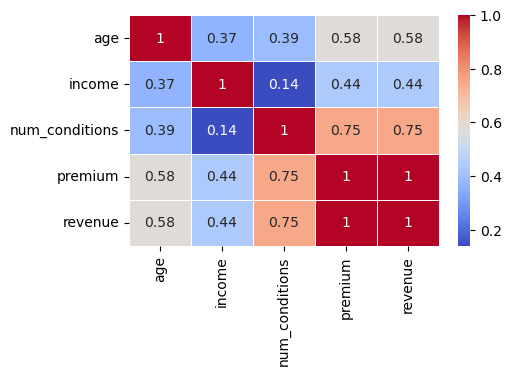

In [11]:
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Display the heatmap
plt.show()

#### Creating new-feature (age-group) to have a better insight of users's age-range through thr 2nd funnel step collect-contact-info step

In [31]:
# Defining the age intervals
bins = [0, 25, 40, 65]
labels = ['0-25', '25-40', '40-65']

# Creating a new column 'age_group' in the dataframe by cutting the 'age' into bins
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

# Group by age_group and funnel_step_sign_and_exam and calculate the size of each group
age_funnel_group = merged_df.groupby(['age_group', 'funnel_step_collect_contact_info']).size().unstack(fill_value=0)

# Calculate the percentage of users who made through and who didn't for each age group
age_funnel_group['Made Through (%)'] = (age_funnel_group[1] / (age_funnel_group[0] + age_funnel_group[1])) * 100
age_funnel_group['Didnt Make (%)'] = (age_funnel_group[0] / (age_funnel_group[0] + age_funnel_group[1])) * 100

# Selecting relevant columns for display
age_funnel_group = age_funnel_group[['Made Through (%)', 'Didnt Make (%)']]

# Display the result
print(age_funnel_group)

funnel_step_collect_contact_info  Made Through (%)  Didnt Make (%)
age_group                                                         
0-25                                     75.843694       24.156306
25-40                                    72.539797       27.460203
40-65                                    70.385881       29.614119


#### Creating new-feature (age-group) to have a better insight of users's age-range through sign_exam step

In [289]:
# Defining the age intervals
bins = [0, 25, 40, 65]
labels = ['0-25', '25-40', '40-65']

# Creating a new column 'age_group' in the dataframe by cutting the 'age' into bins
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

# Group by age_group and funnel_step_sign_and_exam and calculate the size of each group
age_funnel_group = merged_df.groupby(['age_group', 'funnel_step_sign_and_exam']).size().unstack(fill_value=0)

# Calculate the percentage of users who made through and who didn't for each age group
age_funnel_group['Made Through (%)'] = (age_funnel_group[1] / (age_funnel_group[0] + age_funnel_group[1])) * 100
age_funnel_group['Didnt Make (%)'] = (age_funnel_group[0] / (age_funnel_group[0] + age_funnel_group[1])) * 100

# Selecting relevant columns for display
age_funnel_group = age_funnel_group[['Made Through (%)', 'Didnt Make (%)']]

# Display the result
print(age_funnel_group)

funnel_step_sign_and_exam  Made Through (%)  Didnt Make (%)
age_group                                                  
0-25                               7.904085       92.095915
25-40                              8.683068       91.316932
40-65                              6.431349       93.568651


- as we can see almost 8.6% of the users that nade through the funnel where the age 25-40 years old
- the users between 45-60 years old have 6.4% of them continue through the last step. 
- this 2.2% of drop-off might be because the people in this ages are nit comfortable to go through website and sign up applications.
- what I recommend is to add additional feature to the advertising team to help them to submit the application or the phone-connect step be in the early steps that would be easier for older users and can increase the number of users that convert through the funnel and also increase revenue.

# Dummy variables of device and marketing channel features

- In order to compute the correlation of all features, we need to transform all the categorical feature to numerical one. 
- We used one-hot encoding to transform the "device" and "marketing channel"

In [12]:
# Performing one-hot encoding on the two categorical features
merged_df = pd.get_dummies(merged_df, columns=['device', 'marketing_channels'])

# Display the resulting DataFrame
merged_df

,user_id,age,income,num_conditions,premium,funnel_step_started_navigator,funnel_step_collect_contact_info,funnel_step_viewed_quotes,funnel_step_application_submit,funnel_step_phone_connect,funnel_step_sign_and_exam,revenue,device_desktop,device_mobile_android,device_mobile_ios,marketing_channels_facebook,marketing_channels_instagram,marketing_channels_paid_search_nb,marketing_channels_podcast,marketing_channels_tv
0,1001,56,157490,5,2490.123774,1,1,0,0,0,0,3386.568332,1,0,0,0,1,0,0,0
1,1002,34,138171,3,1906.228442,1,1,1,1,1,1,2592.470681,1,0,0,0,0,1,0,0
2,1003,32,94274,2,1515.217172,1,0,0,0,0,0,2060.695353,1,0,0,0,0,1,0,0
3,1004,32,160480,4,2263.763328,1,0,0,0,0,0,3078.718126,1,0,0,0,0,0,0,1
4,1005,33,141943,3,1624.410806,1,0,0,0,0,0,2209.198696,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10996,40,215550,1,1609.973169,1,0,0,0,0,0,2189.563510,0,0,1,0,1,0,0,0
9996,10997,37,243968,5,2719.261020,1,0,0,0,0,0,3698.194987,0,0,1,0,0,1,0,0
9997,10998,49,260298,3,1902.605472,1,1,1,0,0,0,2587.543442,0,0,1,0,1,0,0,0
9998,10999,20,163641,4,1786.076634,1,1,1,0,0,0,2429.064223,0,0,1,0,0,0,1,0


## MODEL-BASED ANALYSIS
In this section, we shows which features are associated with users converting through the funnel

#### age & funnel_step_sign_and_exam

In [17]:
dff = merged_df

X = dff[['age']]
y = dff['funnel_step_sign_and_exam']

# Split the data - 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize a new scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Retrain the model with the correctly scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the correctly scaled test set
y_pred_corrected = model.predict(X_test_scaled)

# Evaluate the corrected model
#classification_report_corrected = classification_report(y_test, y_pred_corrected)
# Get the coefficients of the logistic regression model
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Display the coefficients and intercept
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients: [-0.1376277]
Intercept: -2.48824180378327


#### Income & funnel_step_sign_and_exam

In [19]:
dff = merged_df

X = dff[['income']]
y = dff['funnel_step_sign_and_exam']

# Split the data - 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize a new scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Retrain the model with the correctly scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the correctly scaled test set
y_pred_corrected = model.predict(X_test_scaled)

# Evaluate the corrected model
#classification_report_corrected = classification_report(y_test, y_pred_corrected)
# Get the coefficients of the logistic regression model
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Display the coefficients and intercept
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients: [0.44706956]
Intercept: -2.5691377958841066


#### age & num_conditions

In [20]:
dff = merged_df

X = dff[['age', 'num_conditions']]
y = dff['funnel_step_sign_and_exam']

# Split the data - 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize a new scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Retrain the model with the correctly scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the correctly scaled test set
y_pred_corrected = model.predict(X_test_scaled)

# Evaluate the corrected model
#classification_report_corrected = classification_report(y_test, y_pred_corrected)
# Get the coefficients of the logistic regression model
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Display the coefficients and intercept
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients: [ 0.09385987 -0.58851659]
Intercept: -2.608610464541809


#### income & premium

In [21]:
dff = merged_df

X = dff[['income','premium']]
y = dff['funnel_step_sign_and_exam']

# Split the data - 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize a new scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Retrain the model with the correctly scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the correctly scaled test set
y_pred_corrected = model.predict(X_test_scaled)

# Evaluate the corrected model
#classification_report_corrected = classification_report(y_test, y_pred_corrected)
# Get the coefficients of the logistic regression model
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Display the coefficients and intercept
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients: [ 0.69772216 -0.59494867]
Intercept: -2.683420220040636


#### Marketing_Channel(TV) 

In [29]:
dff = merged_df

X = dff[['premium']]
y = dff['funnel_step_sign_and_exam']

# Split the data - 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize a new scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Retrain the model with the correctly scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the correctly scaled test set
y_pred_corrected = model.predict(X_test_scaled)

# Evaluate the corrected model
#classification_report_corrected = classification_report(y_test, y_pred_corrected)
# Get the coefficients of the logistic regression model
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Display the coefficients and intercept
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients: [-0.25992975]
Intercept: -2.5086390689048783


## Answering questions based on the visualization and model-based analysis

### Question 2
- When looking at revenue generation at a segment level through the funnel, which features are associated with people converting through the funnel?

As we can see through the visualisation per funnel step, We cand see that users with the following features made through the funnel:  Marketing-Channel (Podcast,paid-search-nb), Device(Desktop), Income



- Which features are associated with people that do not convert through the funnel?

Marketing_channel(tv),device(ios, android), numb-conditions

- Are there potentially segments that might have low conversion rates, but are still efficient generators of revenue? 
 
 Yes, we have a large number of user drop-off from view-quotes step to Application-submit step. Eventhough we had a large drop off compare to the other steps but still is efficient. Because this step is the door for user to submeit their applications based on the quotes that is shown in the add. We can say it's the first step of purchasing the life insurance plan.
 
 Also view-quotes step is important.This step is so crucial and marketing team needs to add new features to this step to attract more users. Because in this step, users decide to continue with the insurance plan. So they can add some promotion/discount when show the quotes or offer discount if they register and then refer to a family or friend. 

### Question 3

Hypothesis:
- I was expected the age-range of the people who goes through the 2nd step of funnel(collect-info) should be mostly around 25-40 years old, because normally in this age people have their professional job and buy an insurance plan. But analysis shows that mostly the people with age-range betwen 0-25 wenth through the collect-info step.

- I was expecting the amount of premium would correlate with the number of users go through the funnel but it wasn't.

Recommendation and opportunities for product team:

- Simplify the Insurance Process:Work towards simplifying the application and underwriting process, making it faster and less invasive to nit loose users at the application submit step.

- Develop user-friendly digital platforms: Based on the analysis 50% of the people that converted through the funnel, they used Device (Desktop) to buy the product (life insurance plan). I would recommend to the product team to provide the application of product on (ios, android) to increase the number of users go through the last step of funnel and increase revenue and efficiency. If there is already the application on ios and adroid they can make it more user friendly.

- Design flexible insurance products that can be customized to fit individual needs like premium payment options

### Question 4


Recommendation and opportunities for marketing team:

- Based on the resualts people who saw the add on tv and bought the plan are the smaller group of people, which make sense. from tv people cannot connect to the website of the insurance. What I recommend is to provide a phone number on the add on tv which is also more simple for aged people to contact agent and procedd through the funnel.

- Since converted users thrugh the last step of the funnel are the ones who saw the add on paid-search-nb and podcast, spend more money on advertising through these platforms. Even offer promotions and discount for the users through these platform to increase the revenue and efficiency of the company.

### Question 5

- We need to colect these attributes to have a better insight of our users:

Demographic Information: marital status, number of dependents
Lifestyle and Health Information: Pre-existing medical conditions(diabetes, chronic diagnosis), family medical history, Smoking status, alcohol consumption,

- What are some potential ways you would expand this work?

Product Innovation and Customization: Use insights gained from the data to develop new insurance products or customize existing products to meet the specific needs of different customer segments.

Customer Experience Enhancement: Analyze customer interaction data to identify pain points and areas for improvement in the customer journey

Personalized Marketing and Communication:
Implement personalized marketing strategies based on the collected data to increase engagement and conversion.

